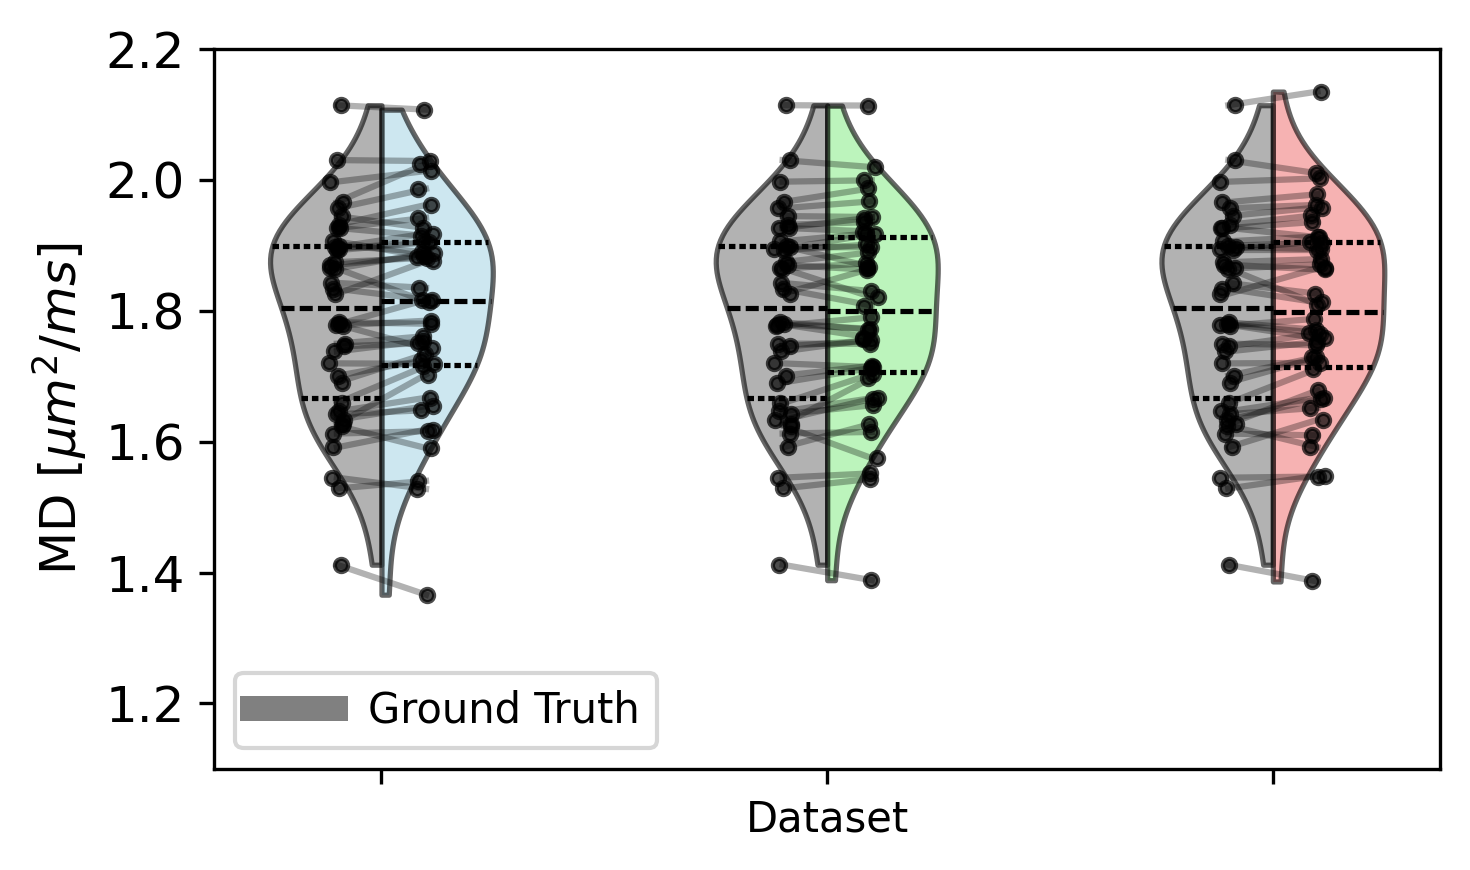

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Define the datasets
runs = ['11', '12', '13']
run_titles = {'11': 'DWI', '12': 'DWI & MD', '13': 'DWI & MD & E1'}

all_data = []

for run in runs:
    main = '/Users/saschastocker/Documents/Stanford/work2024/WholeHeartCropISMRM/nnUNetResults'
    csv_file_path = f'{main}/Run{run}/dice_scores_per_casemedian.csv'
    df = pd.read_csv(csv_file_path)

    # Ensure 'Label' column is of type string
    df['Label'] = df['Label'].astype(str)

    # Filter dataframe to only include 'Label 1'
    df = df[df['Label'] == 'Label 1']

    # Map 'Label' codes to readable names
    label_name_mapping = {
        'Label 1': 'Left Ventricle'
    }
    df['Structure'] = df['Label'].map(label_name_mapping)

    # Add a new column to identify the run
    df['Dataset'] = run_titles[run]

    # Reshape the DataFrame to have 'GT_Median' and 'Pred_median' in a single 'Median' column
    df_melted = pd.melt(
        df,
        id_vars=['Case ID', 'Label', 'Dice Score', 'Dataset'],
        value_vars=['GT_Median', 'Pred_median'],
        var_name='Type',
        value_name='Median'
    )

    # Map 'GT_Median' and 'Pred_median' to 'GT' and 'Pred' in 'Type' column
    df_melted['Type'] = df_melted['Type'].replace({'GT_Median': 'GT', 'Pred_median': 'Pred'})

    # Append to the list
    all_data.append(df_melted)

# Combine all runs into a single DataFrame
combined_df = pd.concat(all_data, ignore_index=True)

# Define colors for GT and specific colors for each dataset's Pred
pred_colors = {
    'DWI': 'lightblue',
    'DWI & MD': 'lightgreen',
    'DWI & MD & E1': 'lightcoral'
}
palette = {'GT': 'grey', 'Pred': 'black'}  # Set general palette for split

# Set up the plot
plt.figure(figsize=(5, 3), dpi=300)

# Draw the split violin plot with dataset-specific colors for Pred side
sns.violinplot(
    x='Dataset',
    y='Median',
    hue='Type',
    data=combined_df,
    split=True,
    inner='quartile',
    palette=palette,
    cut=0,
    width=0.5
)

# Customize the violin colors to match dataset-specific colors for Pred side
for idx, dataset in enumerate(pred_colors):
    # Get all patches (each violin has two parts, one for GT and one for Pred)
    for patch in plt.gca().collections[2*idx:2*idx+2]:  # 2*idx and 2*idx+1 for each split
        # Apply grey color to the left (GT) and dataset-specific color to the right (Pred)
        patch.set_facecolor('grey' if patch.get_paths()[0].vertices[:, 0].min() < idx else pred_colors[dataset])
        patch.set_edgecolor('black')  # Ensure the edge is black
        patch.set_alpha(0.6)

# Overlay individual data points without color
for idx, dataset in enumerate(combined_df['Dataset'].unique()):
    df_dataset = combined_df[combined_df['Dataset'] == dataset]
    
    # Plot GT data points
    data_gt = df_dataset[df_dataset['Type'] == 'GT']['Median'].values
    plt.scatter(
        np.full(len(data_gt), idx - 0.1 + np.random.uniform(-0.02, 0.02, size=len(data_gt))),
        data_gt,
        color='black',
        s=10,
        alpha=0.7
    )
    
    # Plot Pred data points
    data_pred = df_dataset[df_dataset['Type'] == 'Pred']['Median'].values
    plt.scatter(
        np.full(len(data_pred), idx + 0.1 + np.random.uniform(-0.02, 0.02, size=len(data_pred))),
        data_pred,
        color='black',
        s=10,
        alpha=0.7
    )
    
    # Draw connection lines for each paired GT-Pred data point
    for gt, pred in zip(data_gt, data_pred):
        plt.plot([idx - 0.1, idx + 0.1], [gt, pred], color='black', alpha=0.3)

# Set labels and ticks
xticks_labels = [' ','Dataset',' ']
xticks=[0,1,2]
plt.xticks(fontsize=10,ticks=xticks,labels=xticks_labels)
plt.ylabel('MD [$μm^2 / ms$]', fontsize=12)
plt.xlabel('')
plt.ylim(1.1, 2.2)  # Adjust based on your data range
plt.yticks(fontsize=12)
plt.tight_layout()

# Custom legend to include specific Pred colors per dataset
legend_elements = [
    Line2D([0], [0], color='grey', lw=6, label='Ground Truth'),
]
plt.legend(handles=legend_elements, fontsize=10)

plt.show()


In [14]:
import pandas as pd
from scipy.stats import ttest_ind
main = '/Users/saschastocker/Documents/Stanford/work2024/WholeHeartCropISMRM/nnUNetResults'

# Define paths to your CSV files for the three datasets
csv_files = {
    'DWI': f'{main}/Run11/dice_scores_per_casemedian.csv',
    'DWI & MD': f'{main}/Run12/dice_scores_per_casemedian.csv',
    'DWI & MD & E1': f'{main}/Run13/dice_scores_per_casemedian.csv'
}

# Initialize a dictionary to store t-test results
t_test_results = {}

# Process each dataset and perform t-test
for dataset_name, file_path in csv_files.items():
    # Load the CSV file
    df = pd.read_csv(file_path)

    # Filter for 'Label 1' data
    df = df[df['Label'] == 'Label 1']

    # Extract GT and Pred median values
    gt_values = df['GT_Median'].values
    pred_values = df['Pred_median'].values

    # Perform the t-test
    t_stat, p_value = ttest_ind(gt_values, pred_values, equal_var=False)
    t_test_results[dataset_name] = {"t-statistic": t_stat, "p-value": p_value}

# Print the t-test results for each dataset
for dataset, results in t_test_results.items():
    print(f"{dataset} - t-statistic: {results['t-statistic']:.4f}, p-value: {results['p-value']:.4f}")


DWI - t-statistic: -0.2671, p-value: 0.7901
DWI & MD - t-statistic: -0.1605, p-value: 0.8729
DWI & MD & E1 - t-statistic: -0.1805, p-value: 0.8572


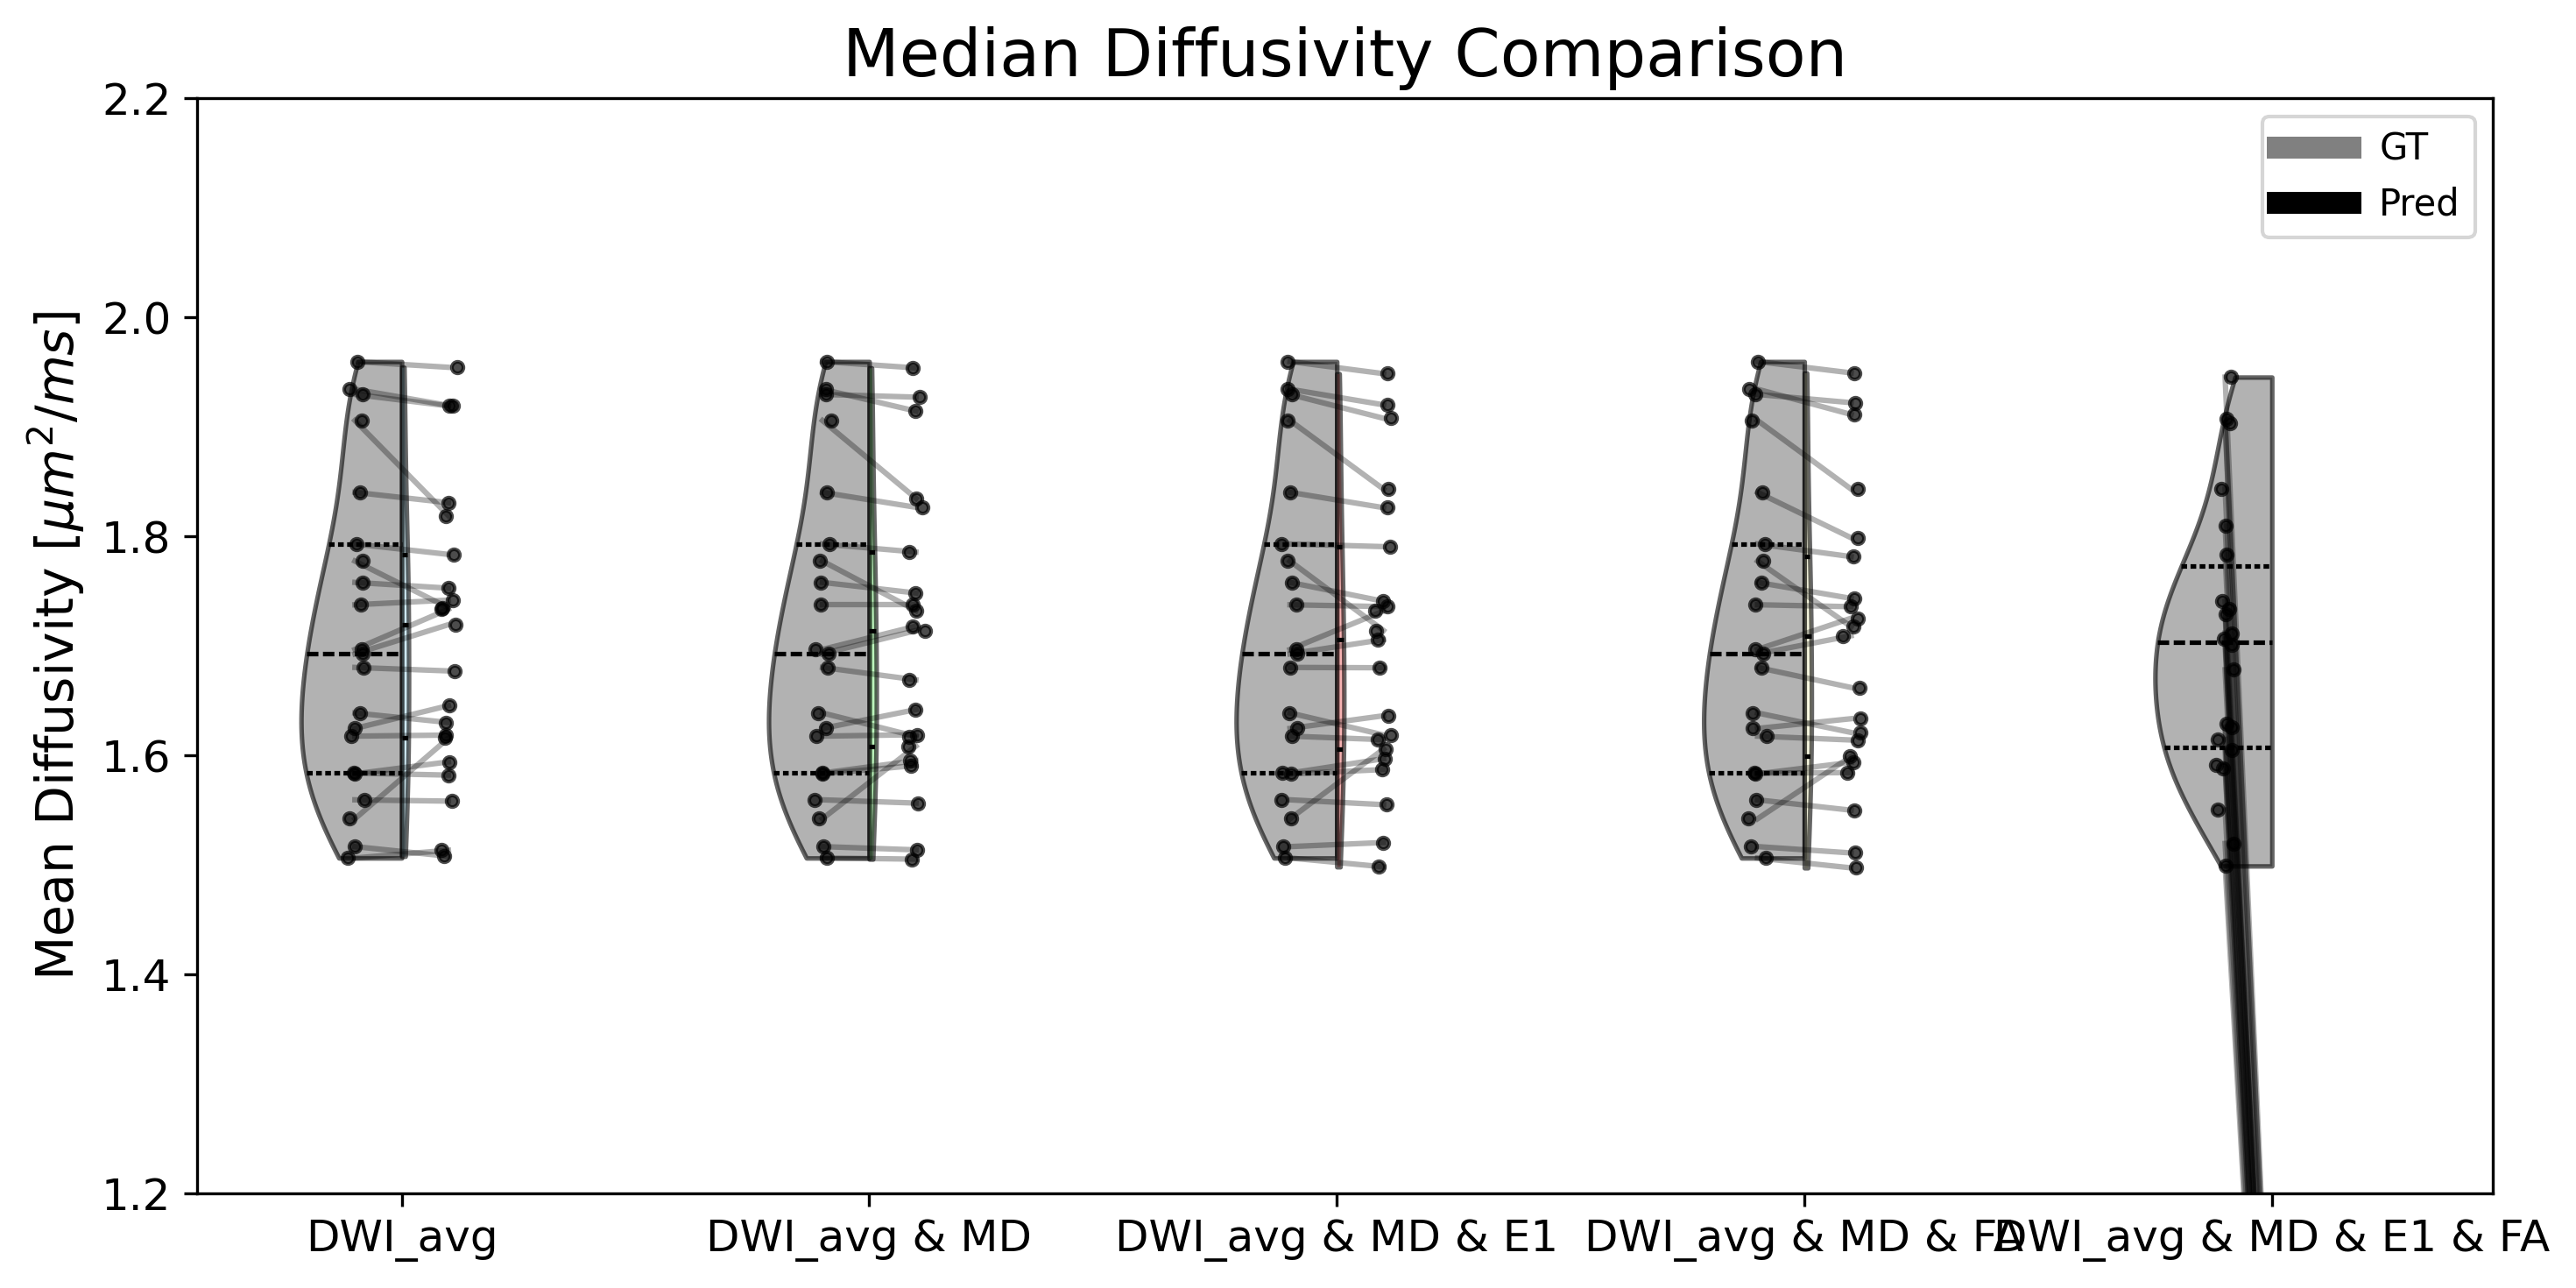

/var/folders/9r/mlgf66555t98p7ptk_n0g21r0000gn/T/ipykernel_58656/4094860928.py:92: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  violin = sns.violinplot(


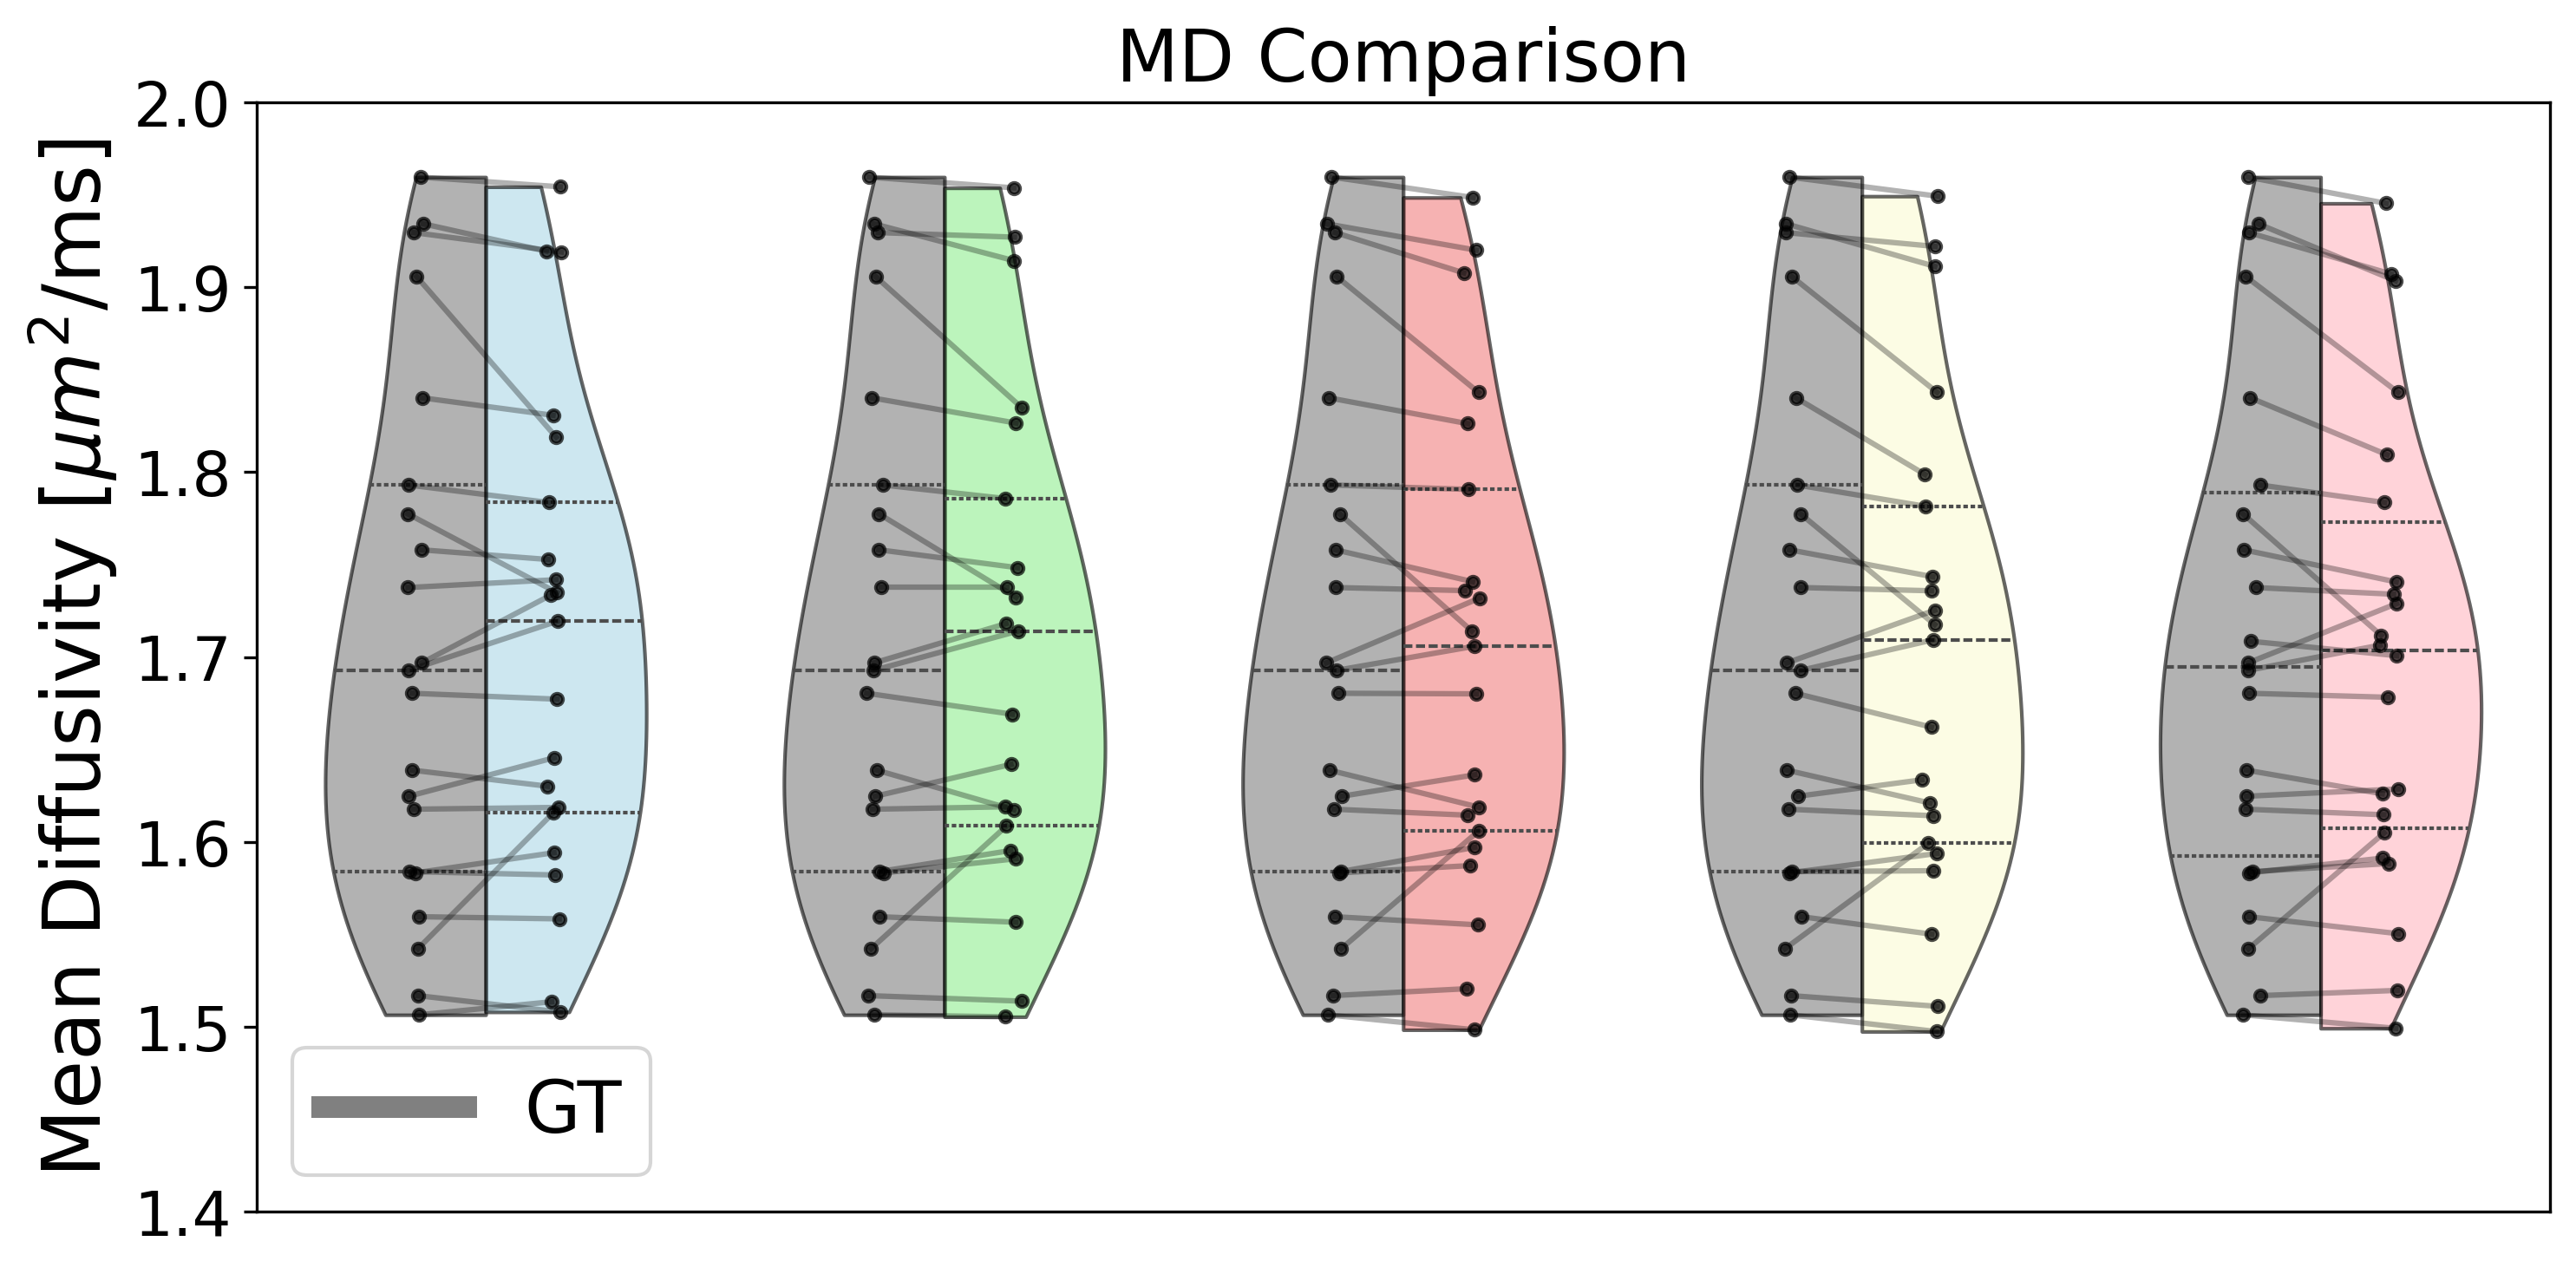

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import PolyCollection
from matplotlib.lines import Line2D
import os

# -----------------------------------------------------------------------------
# A) Data Setup
# -----------------------------------------------------------------------------
runs = ['AVG', 'AVGMD', 'AVGMDE1', 'AVGMDFA', 'all']
run_titles = {
    'AVG': 'DWI_avg',
    'AVGMD': 'DWI_avg & MD',
    'AVGMDE1': 'DWI_avg & MD & E1',
    'AVGMDFA': 'DWI_avg & MD & FA',
    'all': 'DWI_avg & MD & E1 & FA'
}

all_data = []
for run in runs:
    main = '/Users/saschastocker/Documents/Stanford/work2024/FIMH2025/PaperResults'
    csv_file_path = os.path.join(
        main,
        f'HannumVol3specificNorm100EpochSpecficNorm_fold2_{run}_withGTCrop_discoanddirvsagdataDataAugTrainerPAPERRESULTS.xlsx'
    )

    df = pd.read_excel(csv_file_path)
    # Keep relevant columns
    df = df[['Case ID', 'GT_Median_MD', 'Pred_median_MD']]
    # Identify dataset
    df['Dataset'] = run_titles[run]

    # Melt the GT/Pred columns
    df_melted = pd.melt(
        df,
        id_vars=['Case ID', 'Dataset'],
        value_vars=['GT_Median_MD', 'Pred_median_MD'],
        var_name='Type',
        value_name='Median'
    )
    df_melted['Type'] = df_melted['Type'].replace({
        'GT_Median_MD': 'GT',
        'Pred_median_MD': 'Pred'
    })

    all_data.append(df_melted)

combined_df = pd.concat(all_data, ignore_index=True)

# -----------------------------------------------------------------------------
# B) We define a specific x-axis order & create "two-line" labels with subscripts
# -----------------------------------------------------------------------------
dataset_order = [
    'DWI_avg',
    'DWI_avg & MD',
    'DWI_avg & MD & E1',
    'DWI_avg & MD & FA',
    'DWI_avg & MD & E1 & FA'
]

# Remap those long strings to two-line versions with subscript for "avg"
#   - "DWI$_{avg}$" for subscript
#   - Split the rest onto a new line with "\n"
formatted_labels = {
    'DWI_avg': r'DWI$_{avg}$',
    'DWI_avg & MD': r'DWI$_{avg}$' + '\n& MD',
    'DWI_avg & MD & E1': r'DWI$_{avg}$' + '\n& MD & E1',
    'DWI_avg & MD & FA': r'DWI$_{avg}$' + '\n& MD & FA',
    'DWI_avg & MD & E1 & FA': r'DWI$_{avg}$' + '\n& MD & E1 & FA'
}

# -----------------------------------------------------------------------------
# C) Define Colors
# -----------------------------------------------------------------------------
pred_colors = {
    'DWI_avg': 'lightblue',
    'DWI_avg & MD': 'lightgreen',
    'DWI_avg & MD & E1': 'lightcoral',
    'DWI_avg & MD & FA': 'lightgoldenrodyellow',
    'DWI_avg & MD & E1 & FA': 'lightpink'
}
base_palette = {'GT': 'grey', 'Pred': 'grey'}  # We initially draw both sides grey

# -----------------------------------------------------------------------------
# D) Create the Split Violin Plot
# -----------------------------------------------------------------------------
plt.figure(figsize=(10, 5), dpi=300)
plt.title('MD Comparison', fontsize=20)

violin = sns.violinplot(
    x='Dataset',
    y='Median',
    hue='Type',
    data=combined_df,
    order=dataset_order,     # ensures a consistent left-to-right order
    hue_order=['GT', 'Pred'],
    split=True,
    inner='quartile',
    palette=base_palette,
    cut=0,
    scale='width',  # ensures the left and right sides fill the width
    width=0.7,
    linewidth=1
)

# -----------------------------------------------------------------------------
# E) Re-Color the Left (GT) & Right (Pred) Sides
# -----------------------------------------------------------------------------
# Seaborn typically creates 2 polygons per category:
#   index = 2*i     -> left side (GT)
#   index = 2*i + 1 -> right side (Pred)
all_polys = [pc for pc in plt.gca().collections if isinstance(pc, PolyCollection)]
for i, ds_key in enumerate(dataset_order):
    left_patch = all_polys[2*i]       # GT side
    right_patch = all_polys[2*i + 1]  # Pred side

    left_patch.set_facecolor('grey')
    left_patch.set_alpha(0.6)
    left_patch.set_edgecolor('black')

    right_patch.set_facecolor(pred_colors[ds_key])
    right_patch.set_alpha(0.6)
    right_patch.set_edgecolor('black')

# -----------------------------------------------------------------------------
# F) Overlay Data Points & Connection Lines
# -----------------------------------------------------------------------------
for idx, ds_label in enumerate(dataset_order):
    df_dataset = combined_df[combined_df['Dataset'] == ds_label]
    
    # GT
    data_gt = df_dataset[df_dataset['Type'] == 'GT']['Median'].values
    x_gt = np.full(len(data_gt), idx - 0.15) + np.random.uniform(-0.02, 0.02, len(data_gt))
    plt.scatter(x_gt, data_gt, color='black', s=10, alpha=0.7, zorder=10)
    
    # Pred
    data_pred = df_dataset[df_dataset['Type'] == 'Pred']['Median'].values
    x_pred = np.full(len(data_pred), idx + 0.15) + np.random.uniform(-0.02, 0.02, len(data_pred))
    plt.scatter(x_pred, data_pred, color='black', s=10, alpha=0.7, zorder=10)
    
    # Lines connecting GT & Pred for each case
    for xg, xp, yg, yp in zip(x_gt, x_pred, data_gt, data_pred):
        plt.plot([xg, xp], [yg, yp], color='black', alpha=0.3, zorder=9)

# -----------------------------------------------------------------------------
# G) Final Formatting
# -----------------------------------------------------------------------------
# Replace the x-tick labels with our two-line versions
plt.xticks(
 '')

plt.ylabel('Mean Diffusivity [$μm^2$/ms]', fontsize=22)
plt.xlabel('')
plt.ylim(1.4, 2)  # Adjust to your data
plt.yticks(fontsize=17)
plt.xlim(-0.5, 4.5)  # Adjust to your data
plt.tight_layout()

legend_elements = [
    Line2D([0], [0], color='grey', lw=6, label='GT'),
]
plt.legend(handles=legend_elements, fontsize=20)

plt.show()


/var/folders/9r/mlgf66555t98p7ptk_n0g21r0000gn/T/ipykernel_58656/2385450703.py:92: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  violin = sns.violinplot(


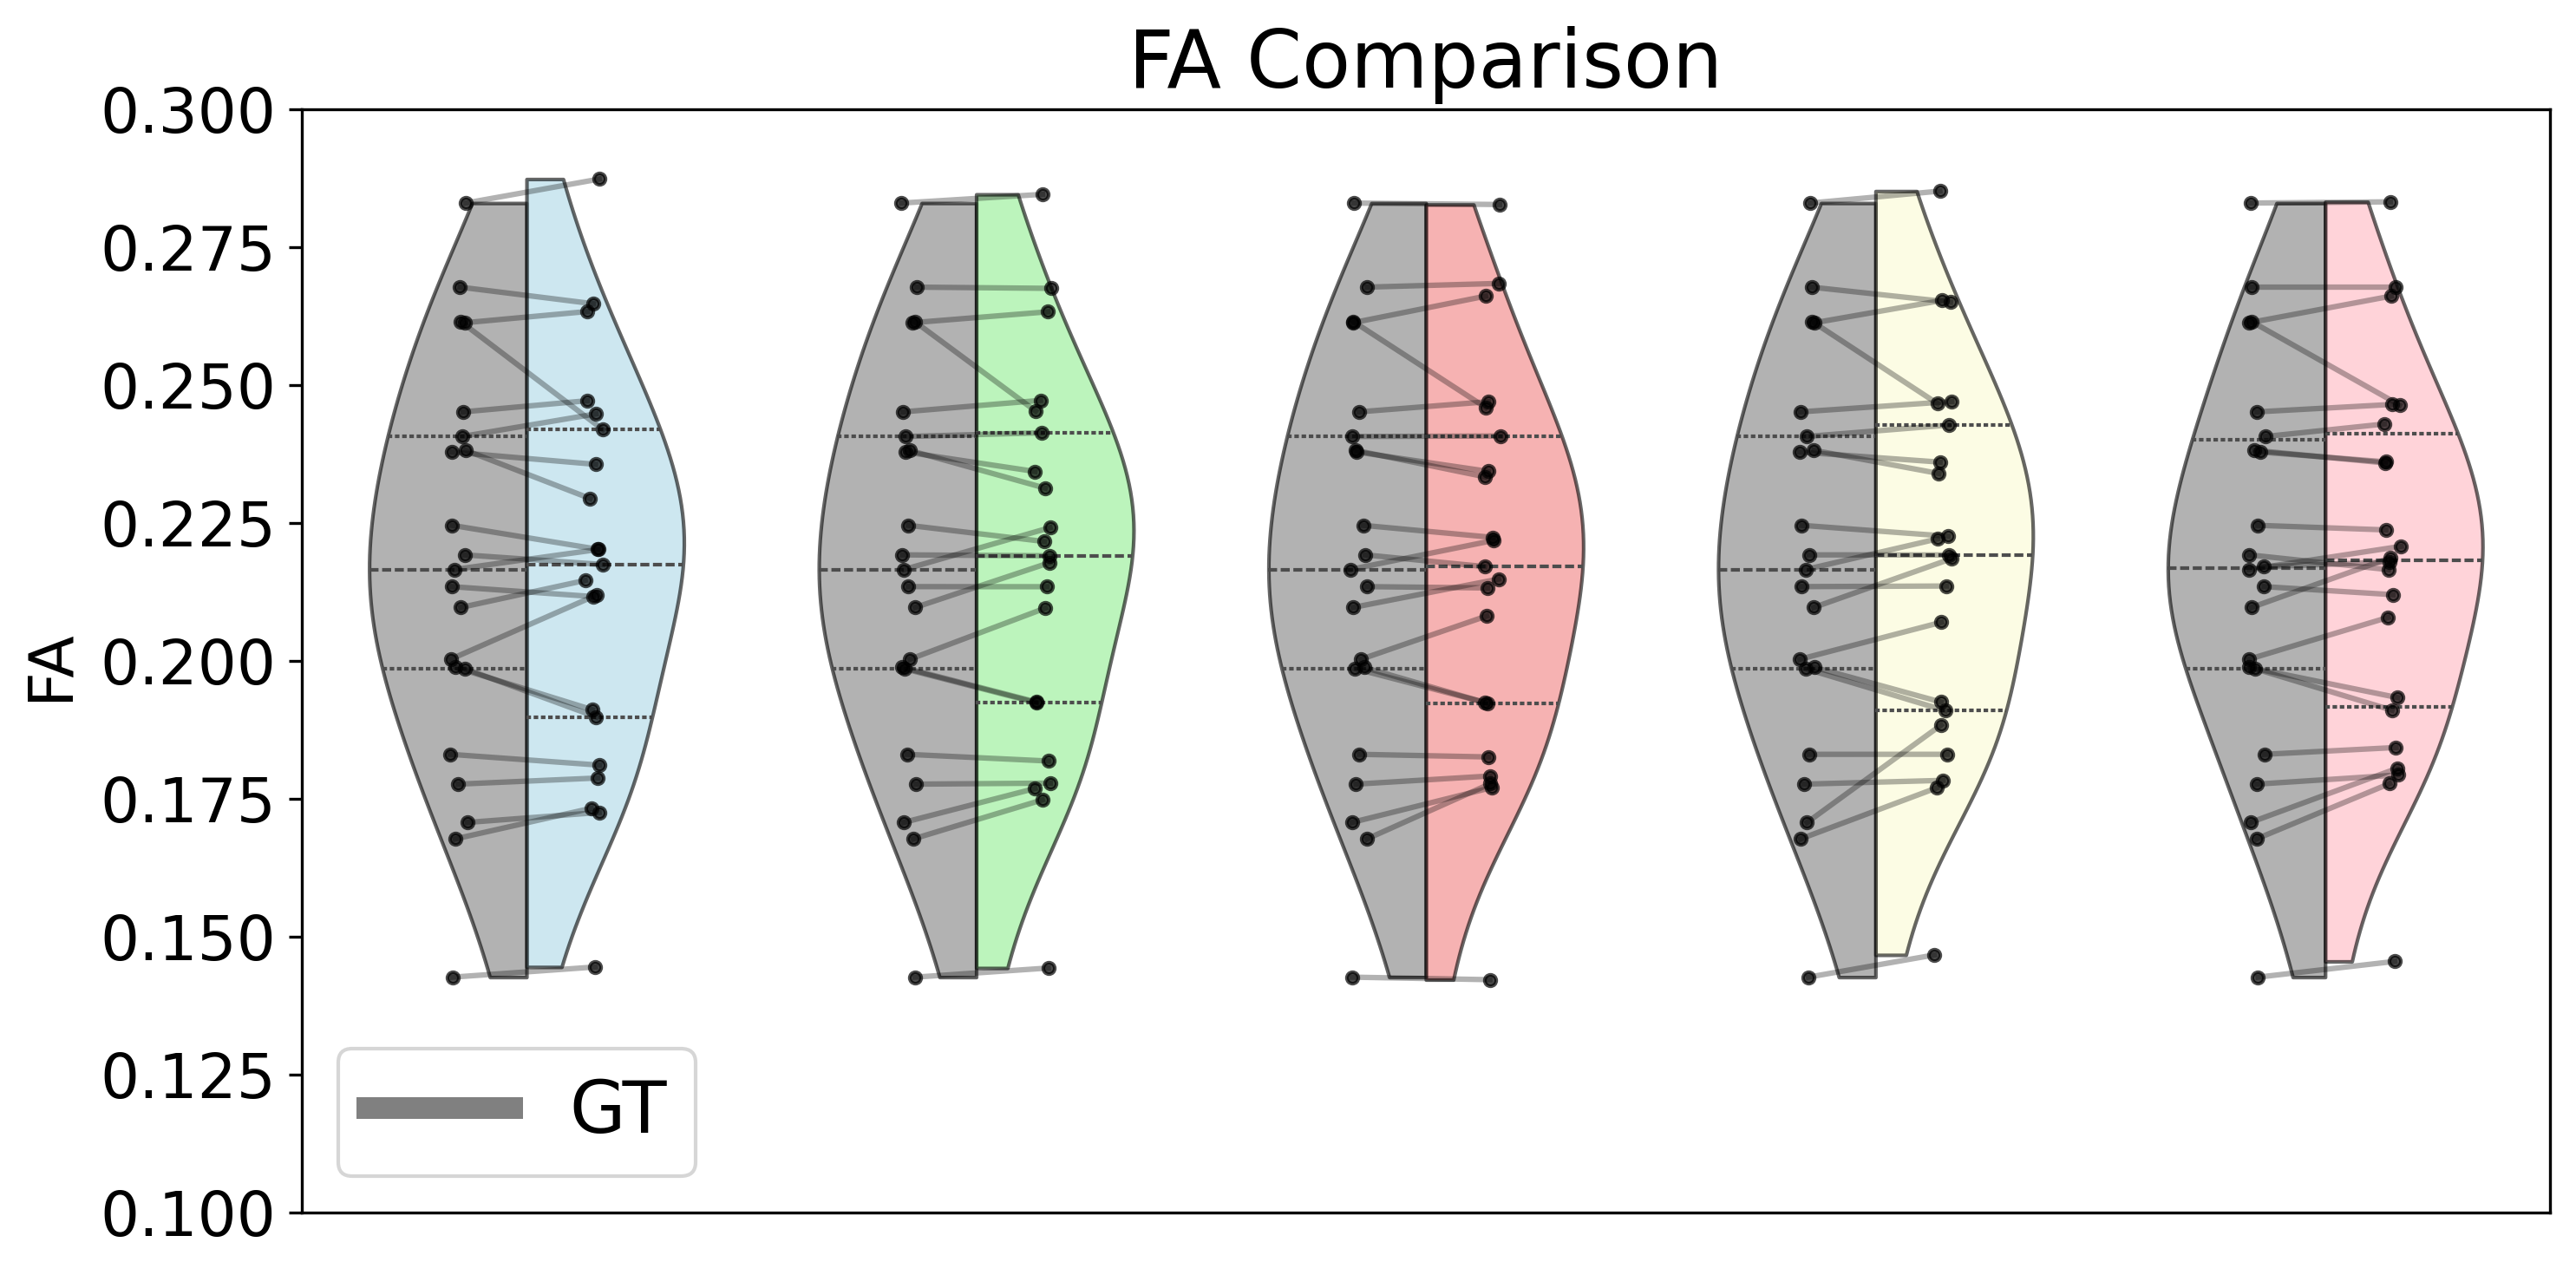

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import PolyCollection
from matplotlib.lines import Line2D
import os

# -----------------------------------------------------------------------------
# A) Data Setup
# -----------------------------------------------------------------------------
runs = ['AVG', 'AVGMD', 'AVGMDE1', 'AVGMDFA', 'all']
run_titles = {
    'AVG': 'DWI_avg',
    'AVGMD': 'DWI_avg & MD',
    'AVGMDE1': 'DWI_avg & MD & E1',
    'AVGMDFA': 'DWI_avg & MD & FA',
    'all': 'DWI_avg & MD & E1 & FA'
}

all_data = []
for run in runs:
    main = '/Users/saschastocker/Documents/Stanford/work2024/FIMH2025/PaperResults'
    csv_file_path = os.path.join(
        main,
        f'HannumVol3specificNorm100EpochSpecficNorm_fold2_{run}_withGTCrop_discoanddirvsagdataDataAugTrainerPAPERRESULTS.xlsx'
    )

    df = pd.read_excel(csv_file_path)
    # Keep relevant columns
    df = df[['Case ID', 'GT_Median_FA', 'Pred_median_FA']]
    # Identify dataset
    df['Dataset'] = run_titles[run]

    # Melt the GT/Pred columns
    df_melted = pd.melt(
        df,
        id_vars=['Case ID', 'Dataset'],
        value_vars=['GT_Median_FA', 'Pred_median_FA'],
        var_name='Type',
        value_name='Median'
    )
    df_melted['Type'] = df_melted['Type'].replace({
        'GT_Median_FA': 'GT',
        'Pred_median_FA': 'Pred'
    })

    all_data.append(df_melted)

combined_df = pd.concat(all_data, ignore_index=True)

# -----------------------------------------------------------------------------
# B) We define a specific x-axis order & create "two-line" labels with subscripts
# -----------------------------------------------------------------------------
dataset_order = [
    'DWI_avg',
    'DWI_avg & MD',
    'DWI_avg & MD & E1',
    'DWI_avg & MD & FA',
    'DWI_avg & MD & E1 & FA'
]

# Remap those long strings to two-line versions with subscript for "avg"
#   - "DWI$_{avg}$" for subscript
#   - Split the rest onto a new line with "\n"
formatted_labels = {
    'DWI_avg': r'DWI$_{avg}$',
    'DWI_avg & MD': r'DWI$_{avg}$' + '\n& MD',
    'DWI_avg & MD & E1': r'DWI$_{avg}$' + '\n& MD & E1',
    'DWI_avg & MD & FA': r'DWI$_{avg}$' + '\n& MD & FA',
    'DWI_avg & MD & E1 & FA': r'DWI$_{avg}$' + '\n& MD & E1 & FA'
}

# -----------------------------------------------------------------------------
# C) Define Colors
# -----------------------------------------------------------------------------
pred_colors = {
    'DWI_avg': 'lightblue',
    'DWI_avg & MD': 'lightgreen',
    'DWI_avg & MD & E1': 'lightcoral',
    'DWI_avg & MD & FA': 'lightgoldenrodyellow',
    'DWI_avg & MD & E1 & FA': 'lightpink'
}
base_palette = {'GT': 'grey', 'Pred': 'grey'}  # We initially draw both sides grey

# -----------------------------------------------------------------------------
# D) Create the Split Violin Plot
# -----------------------------------------------------------------------------
plt.figure(figsize=(10, 5), dpi=300)
plt.title('FA Comparison', fontsize=22)

violin = sns.violinplot(
    x='Dataset',
    y='Median',
    hue='Type',
    data=combined_df,
    order=dataset_order,     # ensures a consistent left-to-right order
    hue_order=['GT', 'Pred'],
    split=True,
    inner='quartile',
    palette=base_palette,
    cut=0,
    scale='width',  # ensures the left and right sides fill the width
    width=0.7,
    linewidth=1
)

# -----------------------------------------------------------------------------
# E) Re-Color the Left (GT) & Right (Pred) Sides
# -----------------------------------------------------------------------------
# Seaborn typically creates 2 polygons per category:
#   index = 2*i     -> left side (GT)
#   index = 2*i + 1 -> right side (Pred)
all_polys = [pc for pc in plt.gca().collections if isinstance(pc, PolyCollection)]
for i, ds_key in enumerate(dataset_order):
    left_patch = all_polys[2*i]       # GT side
    right_patch = all_polys[2*i + 1]  # Pred side

    left_patch.set_facecolor('grey')
    left_patch.set_alpha(0.6)
    left_patch.set_edgecolor('black')

    right_patch.set_facecolor(pred_colors[ds_key])
    right_patch.set_alpha(0.6)
    right_patch.set_edgecolor('black')

# -----------------------------------------------------------------------------
# F) Overlay Data Points & Connection Lines
# -----------------------------------------------------------------------------
for idx, ds_label in enumerate(dataset_order):
    df_dataset = combined_df[combined_df['Dataset'] == ds_label]
    
    # GT
    data_gt = df_dataset[df_dataset['Type'] == 'GT']['Median'].values
    x_gt = np.full(len(data_gt), idx - 0.15) + np.random.uniform(-0.02, 0.02, len(data_gt))
    plt.scatter(x_gt, data_gt, color='black', s=10, alpha=0.7, zorder=10)
    
    # Pred
    data_pred = df_dataset[df_dataset['Type'] == 'Pred']['Median'].values
    x_pred = np.full(len(data_pred), idx + 0.15) + np.random.uniform(-0.02, 0.02, len(data_pred))
    plt.scatter(x_pred, data_pred, color='black', s=10, alpha=0.7, zorder=10)
    
    # Lines connecting GT & Pred for each case
    for xg, xp, yg, yp in zip(x_gt, x_pred, data_gt, data_pred):
        plt.plot([xg, xp], [yg, yp], color='black', alpha=0.3, zorder=9)

# -----------------------------------------------------------------------------
# G) Final Formatting
# -----------------------------------------------------------------------------
# Replace the x-tick labels with our two-line versions
plt.xticks(
    ''
)

plt.ylabel('FA ', fontsize=17)
plt.xlabel('')
plt.ylim(0.1, 0.3) 
plt.xlim(-0.5,4.5) # Adjust to your data
plt.yticks(fontsize=17)
plt.tight_layout()

legend_elements = [
    Line2D([0], [0], color='grey', lw=6, label='GT'),
]
plt.legend(handles=legend_elements, fontsize=20)

plt.show()


In [39]:
import os
import pandas as pd
from scipy.stats import ttest_ind

# Map the descriptive names to the run identifiers
runs = {
    'DWI_avg': 'AVG',
    'DWI_avg & MD': 'AVGMD',
    'DWI_avg & MD & E1': 'AVGMDE1',
    'DWI_avg & MD & FA': 'AVGMDFA',
    'DWI_avg & MD & E1 & FA': 'all'
}

main = '/Users/saschastocker/Documents/Stanford/work2024/FIMH2025/PaperResults'

# Dictionary to store t-test results
t_test_results = {}

for dataset_name, run_key in runs.items():
    # Build the path to the Excel file
    excel_file_path = os.path.join(
        main,
        f'HannumVol3specificNorm100EpochSpecficNorm_fold2_{run_key}_withGTCrop_discoanddirvsagdataDataAugTrainerPAPERRESULTS.xlsx'
    )
    
    # Read the Excel file
    df = pd.read_excel(excel_file_path)

    # In the new dataset, there's no "Label" to filter, so we just compare:
    #   GT_Median_MD  vs.  Pred_median_MD
    gt_values = df['GT_Median_MD'].values
    pred_values = df['Pred_median_MD'].values

    # Perform the two-sample t-test (unequal variances)
    t_stat, p_value = ttest_ind(gt_values, pred_values, equal_var=False)
    
    t_test_results[dataset_name] = {
        "t-statistic": t_stat,
        "p-value": p_value
    }

# Print the results
for dataset, results in t_test_results.items():
    print(f"{dataset} - t-statistic: {results['t-statistic']:.4f}, p-value: {results['p-value']:.4f}")


DWI_avg - t-statistic: 0.0301, p-value: 0.9761
DWI_avg & MD - t-statistic: 0.0764, p-value: 0.9394
DWI_avg & MD & E1 - t-statistic: 0.1122, p-value: 0.9112
DWI_avg & MD & FA - t-statistic: 0.1949, p-value: 0.8465
DWI_avg & MD & E1 & FA - t-statistic: nan, p-value: nan
